In [ ]:
pip install pandas scikit-learn transformers datasets torch matplotlib seaborn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 54.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 50.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.3 MB/s eta 0:00:0000:0100:01
   ━━━

In [ ]:
pip install "accelerate>=0.26.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 18.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
import torch
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
df = pd.read_csv('merged_ai_human_para.csv')

In [ ]:
df.head()

,Unnamed: 0,abstract,label
0,0,Continuous monitoring of crop is an essential ...,0
1,1,The aim of this paper is to propose a distribu...,1
2,2,The use of braincomputer interface BCI technol...,1
3,3,Cardiac MRI segmentation is an essential task ...,1
4,4,This paper proposes a dynamic prediction appro...,1


In [ ]:
# Drop the column named 'Unnamed'
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the count of each class to ensure it is balanced
print(df['label'].value_counts())

label
2    15395
1    15395
0    15391
Name: count, dtype: int64


In [ ]:
df.head()

,abstract,label
0,Histopathology slides are often marked using p...,2
1,Manufacturing enterprises in China always have...,0
2,We offer a multiagent approach based on micros...,2
3,WiFi was developed to support softwaredefined ...,0
4,This paper proposes a Poverty Alleviation Loan...,1


In [ ]:
# Step 2: Split the dataset into training and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Check sizes of train and test sets
print(f"Training Set Size: {len(train_df)}")
print(f"Test Set Size: {len(test_df)}")

Training Set Size: 36944
Test Set Size: 9237


In [ ]:
# Step 3: Tokenize the Data
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

# Tokenize the training data
train_encodings = tokenizer(train_df['abstract'].tolist(), padding=True, truncation=True, max_length=512)

# Create a Dataset for training
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_df['label'].values
})

# Tokenize the test data
test_encodings = tokenizer(test_df['abstract'].tolist(), padding=True, truncation=True, max_length=512)

# Create a Dataset for testing
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_df['label'].values
})

In [ ]:
# Step 4: Initialize Model
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=3)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# Step 5: Set up Training Arguments
training_args = TrainingArguments(
    output_dir='./results_electra_1',          # Output directory for model and checkpoints
    num_train_epochs=5,                     # Number of epochs to train the model
    per_device_train_batch_size=16,         # Batch size for training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    warmup_steps=500,                       # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # Strength of weight decay
    logging_dir='./logs',                   # Directory for storing logs
    logging_steps=10,                       # Log every 10 steps
    eval_strategy="epoch",                  # Evaluate at the end of every epoch
    dataloader_pin_memory=False             # Ensure compatibility with GPU
)

In [ ]:
# Step 6: Define Custom Callback for Logging Metrics
class LogMetricsCallback(TrainerCallback):
    def __init__(self, training_loss, eval_loss, eval_accuracy):
        self.training_loss = training_loss
        self.eval_loss = eval_loss
        self.eval_accuracy = eval_accuracy

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.training_loss.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_loss.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracy.append(logs['eval_accuracy'])

# Initialize empty lists to store metrics
training_loss = []
eval_loss = []
eval_accuracy = []

# Create the callback instance
log_metrics_callback = LogMetricsCallback(training_loss, eval_loss, eval_accuracy)

In [ ]:
# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,                             # The model to be trained
    args=training_args,                      # The training arguments
    train_dataset=train_dataset,             # The training dataset
    eval_dataset=test_dataset,               # The evaluation dataset
    callbacks=[log_metrics_callback]         # Add the custom callback
)

# Step 8: Fine-Tune the Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.124000,0.254255
2,0.112900,0.191676
3,0.038600,0.521392
4,0.001000,0.332954
5,0.000100,0.403187


TrainOutput(global_step=11545, training_loss=0.09492425177429198, metrics={'train_runtime': 2873.0185, 'train_samples_per_second': 64.295, 'train_steps_per_second': 4.018, 'total_flos': 4.860231052271616e+16, 'train_loss': 0.09492425177429198, 'epoch': 5.0})

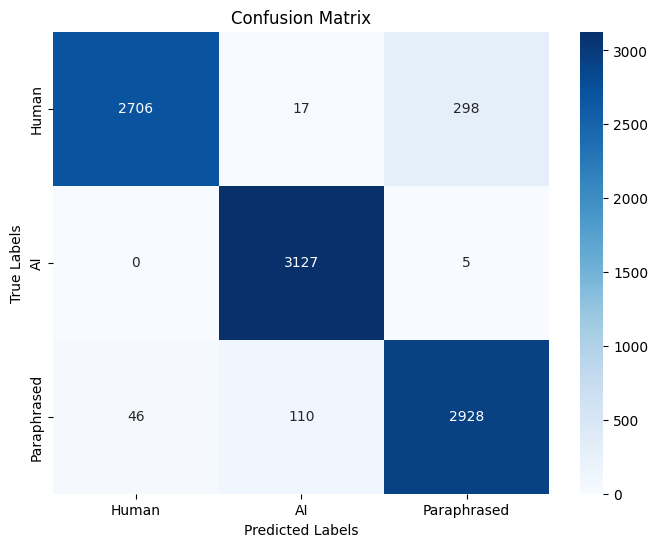

              precision    recall  f1-score   support

       Human       0.98      0.90      0.94      3021
          AI       0.96      1.00      0.98      3132
 Paraphrased       0.91      0.95      0.93      3084

    accuracy                           0.95      9237
   macro avg       0.95      0.95      0.95      9237
weighted avg       0.95      0.95      0.95      9237



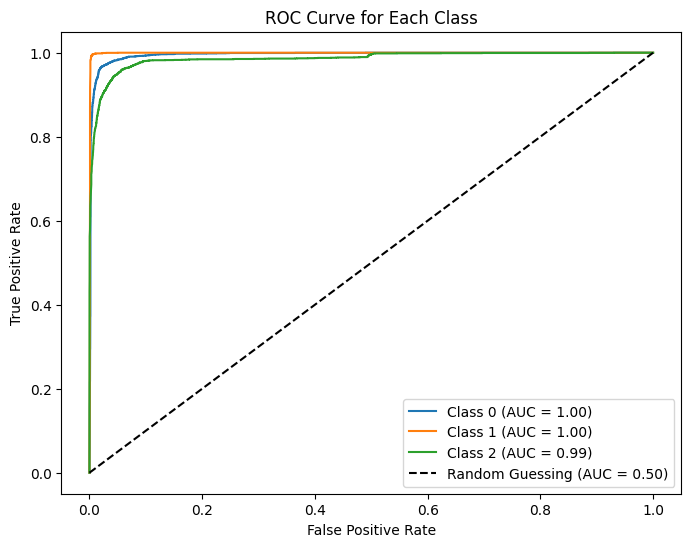

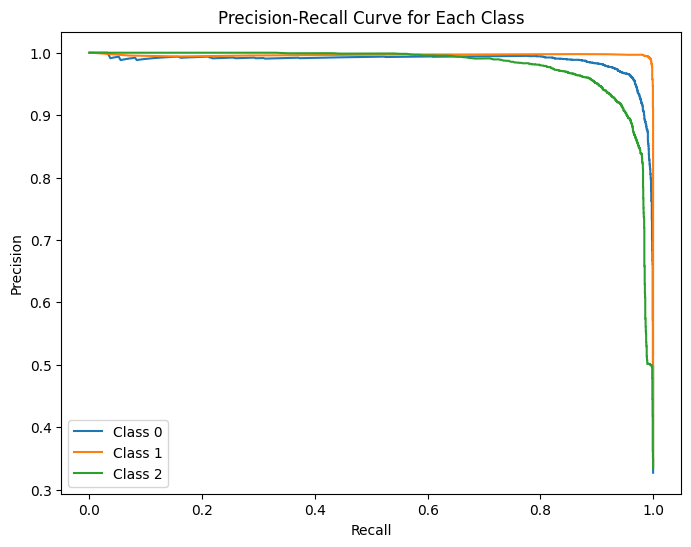

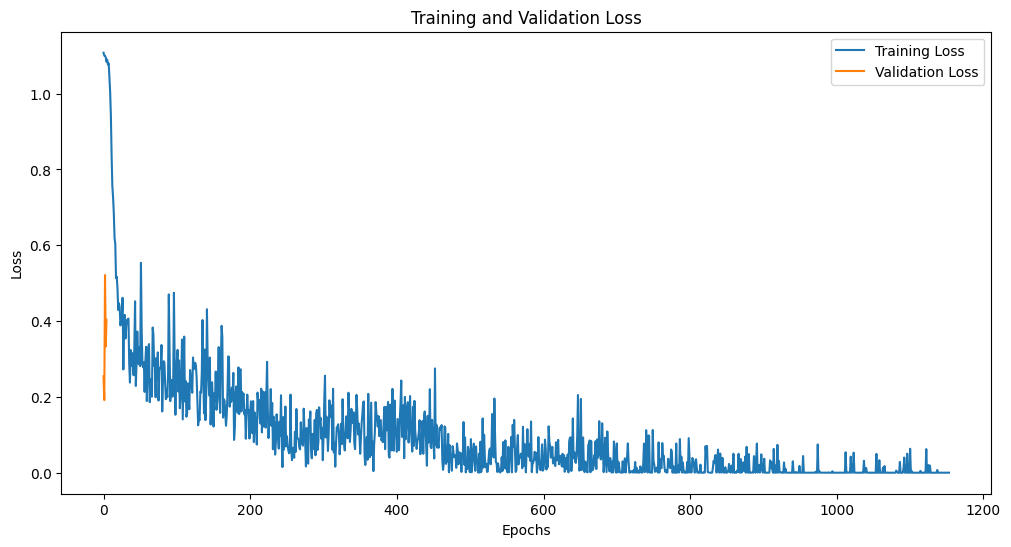

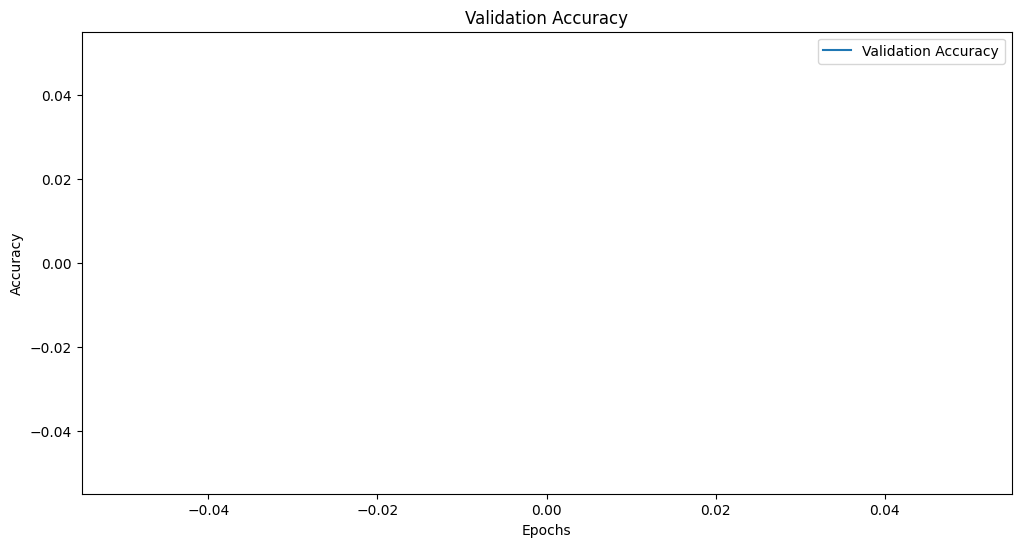

Model and Tokenizer saved.


In [ ]:
# Step 9: Evaluate the Model and Plot Metrics
# Get predictions from the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (the predictions will be logits, so we need to take argmax to get the predicted class)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI', 'Paraphrased'], yticklabels=['Human', 'AI', 'Paraphrased'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Human', 'AI', 'Paraphrased'])
print(report)

# Plot ROC and Precision-Recall Curves
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(true_labels == i, probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend()
plt.show()


# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(3):
    precision, recall, _ = precision_recall_curve(true_labels == i, probs[:, i])
    plt.plot(recall, precision, label=f"Class {i}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()


# Step 10: Plot Training and Validation Accuracy & Loss
# Plot the training loss curve
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy curve
plt.figure(figsize=(12, 6))
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

# Step 11: Save the Fine-Tuned Model and Tokenizer
model.save_pretrained('electra_1_fine_tuned_model')
tokenizer.save_pretrained('electra_1_fine_tuned_model')

print("Model and Tokenizer saved.")